In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os



import tensorflow as tf

2025-06-16 07:39:27.068516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750084767.096383  725638 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750084767.105035  725638 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750084767.129579  725638 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750084767.129606  725638 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750084767.129610  725638 computation_placer.cc:177] computation placer alr

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())
print("GPUs Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
Built with CUDA: True
Built with GPU support: True
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.19.0
Num GPUs Available:  1


In [4]:
current_directory = os.getcwd()
print(current_directory)

/global/u2/k/kberard/SCGSR/Research/Diamond/Testing


In [5]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)
minorized_ref_d = (np.sum(ref_d,axis=2))
minorized_ref_d.shape



(64, 64, 64)


(64, 64)

In [6]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_vmc_samples_1024_0005160960.h5', 'r') as file:
    print("Keys: %s" % file.keys())
    tot_VMC_d = file['density'][:]
#print(ref_d)
print(tot_VMC_d.shape)
minorized_tot_VMC_d = (np.sum(tot_VMC_d,axis=2))
minorized_tot_VMC_d.shape

Keys: <KeysViewHDF5 ['axes', 'centered', 'density', 'density_data_type', 'density_type', 'folding', 'grid', 'nelec', 'points', 'stochastic_type', 'tiling', 'weights']>
(1024, 64, 64, 64)


(1024, 64, 64)

In [7]:
x_test = minorized_tot_VMC_d[900:]
print(x_test.shape)
train_val = minorized_tot_VMC_d[:900]
print(train_val.shape)
sample_mean_ref = np.mean(train_val, axis=0)
print(sample_mean_ref.shape)

(124, 64, 64)
(900, 64, 64)
(64, 64)


In [8]:
from sklearn.model_selection import train_test_split
x_train,x_val = train_test_split(train_val, test_size=.15, train_size=.85, random_state=42, shuffle=True)

In [9]:
print(x_test.shape)
print(x_train.shape)
print(x_val.shape)

(124, 64, 64)
(765, 64, 64)
(135, 64, 64)


In [10]:
y_test = np.zeros((x_test.shape))
y_train = np.zeros((x_train.shape))
y_val = np.zeros((x_val.shape))

for i in range (y_test.shape[0]):
    y_test[i]=sample_mean_ref

for i in range (y_train.shape[0]):
    y_train[i]=sample_mean_ref

for i in range (y_val.shape[0]):
    y_val[i]=sample_mean_ref

# to use DFT ref
"""for i in range (y_test.shape[0]):
    y_test[i]=minorized_ref_d

for i in range (y_train.shape[0]):
    y_train[i]=minorized_ref_d

for i in range (y_val.shape[0]):
    y_val[i]=minorized_ref_d"""

'for i in range (y_test.shape[0]):\n    y_test[i]=minorized_ref_d\n\nfor i in range (y_train.shape[0]):\n    y_train[i]=minorized_ref_d\n\nfor i in range (y_val.shape[0]):\n    y_val[i]=minorized_ref_d'

In [11]:
# Add channel dimension
x_train = x_train[..., np.newaxis]
x_val   = x_val[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

y_train = y_train[..., np.newaxis]
y_val   = y_val[..., np.newaxis]
y_test   = y_test[..., np.newaxis]

In [12]:
# another way of computing JS
"""from scipy.spatial import distance
def jensen_shannon_divergence(P, Q):
    print(P,Q)
    print(type(P))
    P = P.flatten()
    Q = Q.flatten()
    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    return (distance.jensenshannon(P,Q))**2"""

'from scipy.spatial import distance\ndef jensen_shannon_divergence(P, Q):\n    print(P,Q)\n    print(type(P))\n    P = P.flatten()\n    Q = Q.flatten()\n    P = P / np.sum(P)\n    Q = Q / np.sum(Q)\n    return (distance.jensenshannon(P,Q))**2'

In [13]:
import tensorflow as tf

def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


I0000 00:00:1750084779.251358  725638 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37524 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Epoch 1/100


I0000 00:00:1750084782.867109  727454 service.cc:152] XLA service 0x7f59500069b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750084782.867161  727454 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-06-16 07:39:42.916126: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750084783.229792  727454 cuda_dnn.cc:529] Loaded cuDNN version 90300


 99/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4297e-06  

I0000 00:00:1750084786.400061  727454 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.4297e-06 - val_loss: 1.4292e-06
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4290e-06 - val_loss: 1.4283e-06
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4280e-06 - val_loss: 1.4272e-06
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4269e-06 - val_loss: 1.4259e-06
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4255e-06 - val_loss: 1.4244e-06
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4240e-06 - val_loss: 1.4229e-06
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4225e-06 - val_loss: 1.4213e-06
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4209e-06 - val_loss: 1.4196e-06
Epoch 9/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4192e-06 - val_loss: 1.4179e-06
Epoch 10/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4174e-06 - val_loss: 1.4161e-06
Epoch 11/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

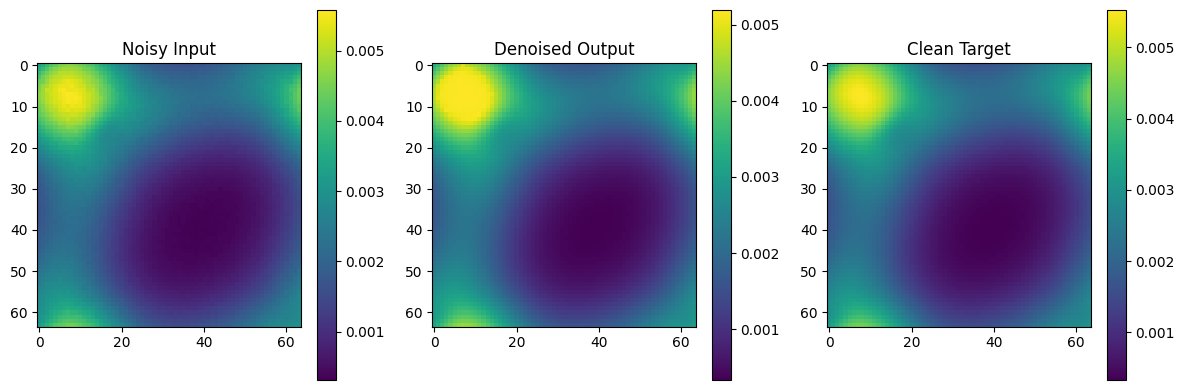

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt



# --- DAE Definition with Channel Dimension Support ---
def create_dae(input_shape):
    def renormalize(x):
        x_sum = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True)
        x = x / (x_sum + 1e-8) * 8.0
        return x
    flat_dim = np.prod(input_shape)
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        
        # Encoder
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        
        # Decoder
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(flat_dim, activation='sigmoid'),
        layers.Reshape(target_shape=input_shape),
        layers.Lambda(renormalize)
    ])
    return model

# --- Main Execution ---
if __name__ == '__main__':
    input_shape = (64, 64, 1)


    dae = create_dae(input_shape)
    # change loss to JS div
    dae.compile(optimizer='adam', loss='mse')

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    dae.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=100,
            batch_size=5,
            callbacks=[early_stop],
            verbose=1)

    # --- Predict and Evaluate ---
    i = 0
    denoised_norm = dae.predict(x_test[i:i+1])[0, ..., 0]
    denoised = denoised_norm
    noisy_input = x_test[i, ..., 0]
    true_clean = y_test

    # --- Plot ---
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input, cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised, cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(true_clean[0,:,:,0], cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


    
    

In [21]:
# norm check after denosing and check that the norm of the denormalized y is the same as the refernce 
print(np.linalg.norm(denoised)-np.linalg.norm(true_clean[0,:,:,0]))
print(np.linalg.norm(true_clean[0,:,:,0]))
#print(true_clean)
print(np.linalg.norm(y_test[0]))

-2.4902926496761513e-06
0.1465650367842726
0.1465650367842726


In [22]:
print(denoised)


[[0.00336443 0.0036113  0.0038842  ... 0.00295773 0.003031   0.00316473]
 [0.00361244 0.00387815 0.00415484 ... 0.00311317 0.00322007 0.00338782]
 [0.00388192 0.00415383 0.00442235 ... 0.00330187 0.00344295 0.00363923]
 ...
 [0.00295613 0.00311417 0.00330147 ... 0.00271811 0.00276668 0.00284299]
 [0.00303109 0.00322063 0.00344268 ... 0.0027651  0.00281106 0.00289509]
 [0.00316395 0.00338833 0.00364035 ... 0.00284345 0.00289426 0.00299899]]


In [23]:
print(true_clean[0,:,:,0])

[[0.00335897 0.00360506 0.0038763  ... 0.00295437 0.00302717 0.00316067]
 [0.003606   0.00387001 0.00414452 ... 0.00310887 0.00321549 0.00338272]
 [0.00387392 0.00414361 0.00440738 ... 0.00329717 0.00343779 0.00363266]
 ...
 [0.00295282 0.00311034 0.00329691 ... 0.00271579 0.00276383 0.00284006]
 [0.0030275  0.00321572 0.00343687 ... 0.00276296 0.00280839 0.00289216]
 [0.00315997 0.00338295 0.00363385 ... 0.00284034 0.00289105 0.00299542]]


In [24]:
# check norm before denoising 
print(x_test[0,:,:,0])
print(np.linalg.norm(x_test[0,:,:,0])-np.linalg.norm(true_clean[0,:,:,0]))

[[0.00336817 0.00359332 0.00387409 ... 0.00295352 0.00304323 0.00310214]
 [0.00363091 0.00386033 0.00415078 ... 0.00308644 0.0031901  0.00339762]
 [0.00384037 0.00419592 0.00442088 ... 0.00329687 0.00341836 0.00364176]
 ...
 [0.00296766 0.00313701 0.00330249 ... 0.00267179 0.00276092 0.00281963]
 [0.00304827 0.00318332 0.00342785 ... 0.00277196 0.00280762 0.00284773]
 [0.00313643 0.00340111 0.00362394 ... 0.00288958 0.00290256 0.00295895]]
1.3356941478415152e-05


In [25]:
#check divergence of denoised vs not denoised matrix
print("DAE JSD (denoised vs. clean):", jensen_shannon_divergence_loss(dae.predict(x_test), y_test))
print("DAE JSD (noise vs. clean):", jensen_shannon_divergence_loss(x_test, y_test))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
DAE JSD (denoised vs. clean): tf.Tensor(1.31982115e-05, shape=(), dtype=float32)
DAE JSD (noise vs. clean): tf.Tensor(1.3202337e-05, shape=(), dtype=float32)


In [26]:
#check the number of electrons
# need to ensure this is kept true throught taining
print("number of electron is should = 8",np.sum(denoised.sum(axis=1)))


number of electron is should = 8 8.0


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 1.8061e-06 - val_loss: 1.2770e-06
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1203e-06 - val_loss: 1.0913e-06
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6918e-07 - val_loss: 1.1456e-07
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4144e-08 - val_loss: 5.3233e-08
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0951e-08 - val_loss: 4.5959e-08
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4795e-08 - val_loss: 4.1294e-08
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0509e-08 - val_loss: 3.8709e-08
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8274e-08 - val_loss: 3.7096e-08
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6767e-08 - val_loss: 3.5828e-08
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5553e-08 - val_loss: 3.4735e-08
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4486e

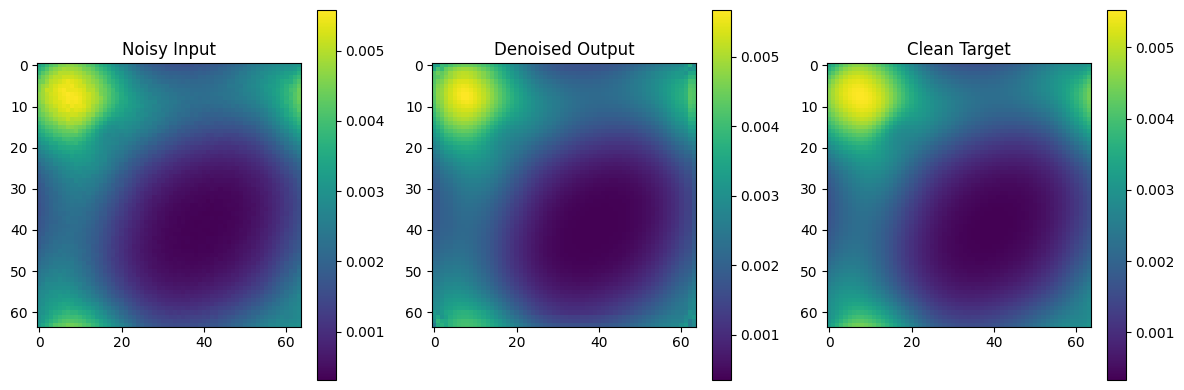

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt



def create_cae(input_shape, target_sum=8.0):
    input_layer = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)  # use relu to ensure non-negativity

    # Renormalize output to have a fixed sum (e.g., 8 electrons)
    def renormalize(x):
        x_sum = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True)
        return x / (x_sum + 1e-8) * target_sum

    output_layer = layers.Lambda(renormalize)(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# --- Main ---
if __name__ == '__main__':
    input_shape = (64, 64, 1)  # CAE expects 4D shape with channel

    # Create model
    cae = create_cae(input_shape)
    cae.compile(optimizer='adam', loss='mse')



    # --- Early stopping ---
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # --- Train ---
    cae.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=100,
            batch_size=20,
            callbacks=[early_stop],
            verbose=1)

    # --- Predict and plot ---
    i = 0  # test sample index
    denoised_norm = cae.predict(x_test[i:i+1])[0, ..., 0]
    denoised = denoised_norm

    # --- Plot ---
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i, ..., 0], cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised, cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(y_test[0], cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()



In [28]:
#check the number of electrons
print("number of electron is should = 8",np.sum(denoised.sum(axis=1)))


number of electron is should = 8 7.9999995


In [29]:
# norm check after denosing and check that the norm of the denormalized y is the same as the refernce 
print(np.linalg.norm(denoised)-np.linalg.norm(true_clean[0,:,:,0]))
print(np.linalg.norm(true_clean[0,:,:,0]))
print(np.linalg.norm(y_test[0]))

-0.00011873425112288172
0.1465650367842726
0.1465650367842726


In [30]:
# check norm before denoising 
print(x_test[0,:,:,0])
print(np.linalg.norm(x_test[0,:,:,0])-np.linalg.norm(true_clean[0,:,:,0]))

[[0.00336817 0.00359332 0.00387409 ... 0.00295352 0.00304323 0.00310214]
 [0.00363091 0.00386033 0.00415078 ... 0.00308644 0.0031901  0.00339762]
 [0.00384037 0.00419592 0.00442088 ... 0.00329687 0.00341836 0.00364176]
 ...
 [0.00296766 0.00313701 0.00330249 ... 0.00267179 0.00276092 0.00281963]
 [0.00304827 0.00318332 0.00342785 ... 0.00277196 0.00280762 0.00284773]
 [0.00313643 0.00340111 0.00362394 ... 0.00288958 0.00290256 0.00295895]]
1.3356941478415152e-05


In [31]:
#check divergence of denoised vs not denoised matrix
print("DAE JSD (denoised vs. clean):", jensen_shannon_divergence_loss(cae.predict(x_test), y_test))
print("DAE JSD (noise vs. clean):", jensen_shannon_divergence_loss(x_test, y_test))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
DAE JSD (denoised vs. clean): tf.Tensor(6.9325244e-05, shape=(), dtype=float32)
DAE JSD (noise vs. clean): tf.Tensor(1.3202337e-05, shape=(), dtype=float32)


In [32]:
print(denoised)


[[0.00338279 0.00340812 0.00400401 ... 0.00311057 0.00367376 0.00290688]
 [0.00355655 0.00414428 0.00395269 ... 0.00328766 0.00303807 0.00319392]
 [0.00420518 0.00448294 0.00437677 ... 0.00310979 0.00349685 0.00351566]
 ...
 [0.00315082 0.00350166 0.003132   ... 0.00281186 0.00296409 0.00317288]
 [0.00295526 0.00382053 0.0035608  ... 0.00291548 0.00259616 0.00291641]
 [0.00259991 0.00364174 0.00373309 ... 0.00315658 0.00255647 0.00285772]]


In [33]:
print(y_test[0,:,:,0])

[[0.00335897 0.00360506 0.0038763  ... 0.00295437 0.00302717 0.00316067]
 [0.003606   0.00387001 0.00414452 ... 0.00310887 0.00321549 0.00338272]
 [0.00387392 0.00414361 0.00440738 ... 0.00329717 0.00343779 0.00363266]
 ...
 [0.00295282 0.00311034 0.00329691 ... 0.00271579 0.00276383 0.00284006]
 [0.0030275  0.00321572 0.00343687 ... 0.00276296 0.00280839 0.00289216]
 [0.00315997 0.00338295 0.00363385 ... 0.00284034 0.00289105 0.00299542]]
